In [7]:
%matplotlib ipympl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
from impedance.preprocessing import readCSV, readBioLogic
from impedance.visualization import plot_nyquist,plot_bode

In [8]:
@element(num_params=3, units=["Ohm", "F", ""],overwrite=True)
def TLMuni(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, Q, alpha = p[0], p[1], p[2]
    Z= 2*np.sqrt(R1/((omega*1j)**alpha*Q))*(1/(np.tanh(np.sqrt((1j*omega)**alpha*R1*Q))))
    return Z

@element(num_params=5, units=["Ohm", "Ohm F", "Ohm F","",""],overwrite=True)
def TLMtwo(p,f):
   
    omega = 2 * np.pi * np.array(f)
    R1, R1Q, R2Q, delta1, alpha = p[0], p[1], p[2], p[3], p[4]
    delta2=1-delta1
    k12=R2Q/R1Q
    wc1=1/(R1Q)
    wc2=1/(R2Q)
    S1=np.sqrt((omega*1j)**alpha/wc1)
    S2=np.sqrt((omega*1j)**alpha/wc2)
    C1=1/np.tanh(delta1*S1)
    C2=1/np.tanh(delta2*S2)

    Z=2*(R1)*(C1*C2*S1*k12+S2)/(S1*(C2*S1*k12+C1*S2))

    return Z

@element(num_params=4, units=["Ohm", "Ohm F", "Ohm F", ""],overwrite=True)
def TLMlinnew(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R1Q, R2Q, alpha = p[0], p[1], p[2], p[3]
    Q=R1Q/R1
    R2=R2Q/Q
    t12=R1/R2
    S=np.sqrt((1j*omega)**alpha*R1*Q)
    kk1=-2/3*(S*(t12**(-1/2)/(t12-1)))
    kk2=-2/3*(t12*S/(t12-1))
    Z=[]
    for omg in omega:
        S=np.sqrt((1j*omg)**alpha*R1*Q)
        kk1=-2/3*(S*(t12**(-1/2)/(t12-1)))
        kk2=-2/3*(t12*S/(t12-1))
        Zelem = (2*R1/S)*(mp.besseli(1/3, kk1)*mp.besseli(2/3, kk2)-mp.besseli(-1/3, kk1)*mp.besseli(-2/3, kk2))/((mp.besseli(-1/3, kk1))*mp.besseli(1/3, kk2)-mp.besseli(1/3, kk1)*mp.besseli(-1/3, kk2))
        Zelem=mp.nstr(Zelem,n=50)
        Zelem = Zelem.replace(' ','').replace('(','').replace(')','') 
        Z.append(Zelem)

    Z=np.asarray(Z,dtype=complex)
    return Z


@element(num_params=4, units=["Ohm", "Ohm F", "Ohm F", ""],overwrite=True)
def TLMlinzert(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R1Q, R2Q, alpha = p[0], p[1], p[2], p[3]
    Q=R1Q/R1
    R2=R2Q/Q
    eps=(R2-R1)/R1
    S=np.sqrt((R1*Q*(omega*1j)**alpha))

    #second expansion
    Z=2*4*R1*(np.exp(4*S)+2*np.exp(2*S)+1)*(np.exp(2*S)+1)*S/((((S**4-2/3*(S**3)+2*S**2-5/2*S+1/8)*eps**2+(4*S**3+S)*eps-4*S**2)*np.exp(2*S)+((-S**4-2/3*(S**3)-2*S**2-5/2*S-1/8)*eps**2+(4*S**3+S)*eps+4*S**2)*np.exp(4*S)+(4*S**2-S*eps+7/8*(eps**2))*np.exp(6*S)-4*S**2-S*eps-7*eps**2*(1/8)))
    return Z

@element(num_params=4, units=["Ohm", "Ohm F", "Ohm F", ""],overwrite=True)
def TLMilin(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R1Q, R2Q, alpha = p[0], p[1], p[2], p[3]
    Q=R1Q/R1
    R2=R2Q/Q
    t12=R1/R2
    wclin1=1/(R1*Q)
    wclin2=1/(R2*Q)
    S1=np.sqrt((1j*omega)**alpha/wclin1)
    S2=np.sqrt((1j*omega)**alpha/wclin2)
    
    Z = -(2*1j*R1/S1)*(((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(0,-2*1j*S1/(t12-1))))-((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(0,-2*1j*S1/(t12-1)))))/(((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(1,-2*1j*S1/(t12-1))))-((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(1,-2*1j*S1/(t12-1)))))
    
    return Z

@element(num_params=4, units=["Ohm", "Ohm F", "Ohm F", ""],overwrite=True)
def TLMilinnew(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R1Q, R2Q, alpha = p[0], p[1], p[2], p[3]
    Q=R1Q/R1
    R2=R2Q/Q
    t12=R1/R2
    wclin1=1/(R1*Q)
    wclin2=1/(R2*Q)
    Z=[]
    for omg in omega:
        S1=np.sqrt((1j*omg)**alpha/wclin1)
        S2=np.sqrt((1j*omg)**alpha/wclin2)
        Zelem = -(2*1j*R1/S1)*(((mp.bessely(1,-2*1j*t12*S2/(t12-1)))*(mp.besselj(0,-2*1j*S1/(t12-1))))-((mp.besselj(1,-2*1j*t12*S2/(t12-1)))*(mp.bessely(0,-2*1j*S1/(t12-1)))))/(((mp.besselj(1,-2*1j*t12*S2/(t12-1)))*(mp.bessely(1,-2*1j*S1/(t12-1))))-((mp.bessely(1,-2*1j*t12*S2/(t12-1)))*(mp.besselj(1,-2*1j*S1/(t12-1)))))
        Zelem=mp.nstr(Zelem,n=50)
        Zelem = Zelem.replace(' ','').replace('(','').replace(')','') 
        Z.append(Zelem)

    Z=np.asarray(Z,dtype=complex)
    
    return Z


@element(num_params=4, units=["Ohm", "Ohm F", "Ohm F", ""],overwrite=True)
def TLMilinzert(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R1Q, R2Q, alpha = p[0], p[1], p[2], p[3]
    Q=R1Q/R1
    R2=R2Q/Q
    wclin1=1/(R1*Q)
    eps=R1/R2-1
    S=np.sqrt((1j*omega)**alpha/wclin1)

    Z=2*R1*4*(np.exp(4*S)+2*np.exp(2*S)+1)*(np.exp(2*S)+1)*S/((((S**4+2*S**3+2*S**2+3/2*S+9/8)*eps**2+(-4*S**3-S)*eps-4*S**2)*np.exp(2*S)+((-S**4+2*S**3-2*S**2+3/2*S-9/8)*eps**2+(-4*S**3-S)*eps+4*S**2)*np.exp(4*S)+(-(1/8)*eps**2+S*eps+4*S**2)*np.exp(6*S)-4*S**2+S*eps+(1/8)*eps**2))
    
    return Z

def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [17]:
Q=6.61e-4
alpha=1

R1=5.22*194.5
delta1=0.12
R2=3.47*194.5
delta2=0.17
R3=2.15*194.5


#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
# Rhfr=40
# Rrxn=40
Qdl=1e-5
alpha2=1

In [18]:
# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,R3*Q,delta1,delta2,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMthree_1-R_1-p(R_2,CPE_1)")

cmodel1=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha,Qdl,alpha2],circuit="p(TLMtwo_1,CPE_1)")

cmodel2=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha],circuit="TLMtwo_1")

# cmodel2=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha],circuit="TLMtwo_1")

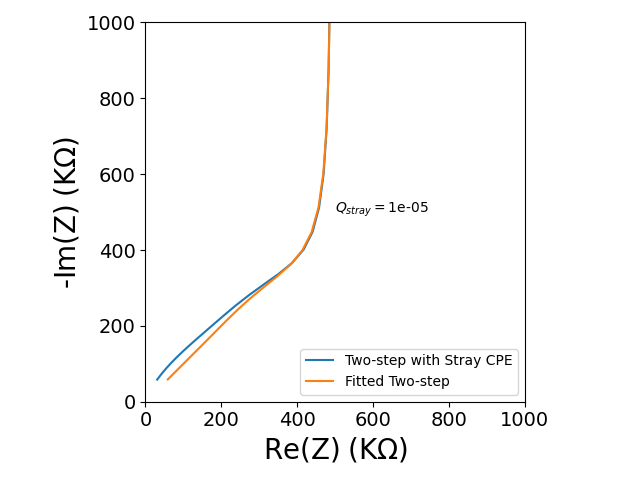

In [31]:
f=np.logspace(-3,2)
z1=cmodel1.predict(frequencies=f)
cmodel2.fit(impedance=z1,frequencies=f)
z2=cmodel2.predict(frequencies=f)

fig, ax=plt.subplots()
ax.plot(np.real(z1),-np.imag(z1),label="Two-step with Stray CPE")
ax.plot(np.real(z2),-np.imag(z2),label="Fitted Two-step")
txt="$Q_{stray}=$"+f"{Qdl}"
ax.text(500,500,txt)
ax.legend(fontsize=18)
ax.set_xlabel("Re(Z)$\;($K$\Omega$)",fontsize=20)
ax.set_ylabel("-Im(Z)$\;($K$\Omega$)",fontsize=20)
ax.tick_params(labelsize=14)
ax.set_aspect("equal")
ax.set_xlim(0,1000)
ax.set_ylim(0,1000)
ax.legend()
fig.tight_layout()
fig.savefig("stray CPE.png",dpi=700)